In [1]:
# !pip install oolearning --upgrade

In [2]:
import oolearning as oo
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sborn

pd.set_option('display.width', 500)
pd.set_option('display.max_colwidth', -1)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [3]:
width = 12
plt.rcParams['figure.figsize'] = [width, width/1.333]

# Explore Dataset

In [4]:
explore = oo.ExploreClassificationDataset.from_csv(target_variable='deposit',
                                                   csv_file_path='df_out.csv',
                                                   separator=';')

In [5]:
explore.dataset.head(10)

,x1,x2,deposit
0,-7.994483,4.520217,yes
1,-0.086969,6.676977,yes
2,-0.274223,6.748554,yes
3,-0.359498,4.435130,yes
4,-0.023651,4.836315,yes
5,-0.520107,3.786314,yes
6,0.089198,6.540989,yes
7,1.121567,3.885942,yes
8,1.919671,2.372270,yes
9,-2.744057,6.404088,yes


In [6]:
explore.categoric_summary()

,count,nulls,perc_nulls,top,unique,perc_unique
deposit,11083,0,0.0,no,2,0.0


In [7]:
explore.numeric_summary()

,count,nulls,perc_nulls,num_zeros,perc_zeros,mean,st_dev,coef of var,skewness,kurtosis,min,10%,25%,50%,75%,90%,max
x1,11083,0,0.0,0,0.0,-0.0,7.442,-2.082921e+15,-0.826,-0.005,-21.644,-11.030,-3.895,0.669,6.501,8.127,9.307
x2,11083,0,0.0,0,0.0,0.0,7.631,3.527665e+15,-0.532,-0.625,-21.142,-11.777,-6.513,2.549,5.460,7.865,13.316


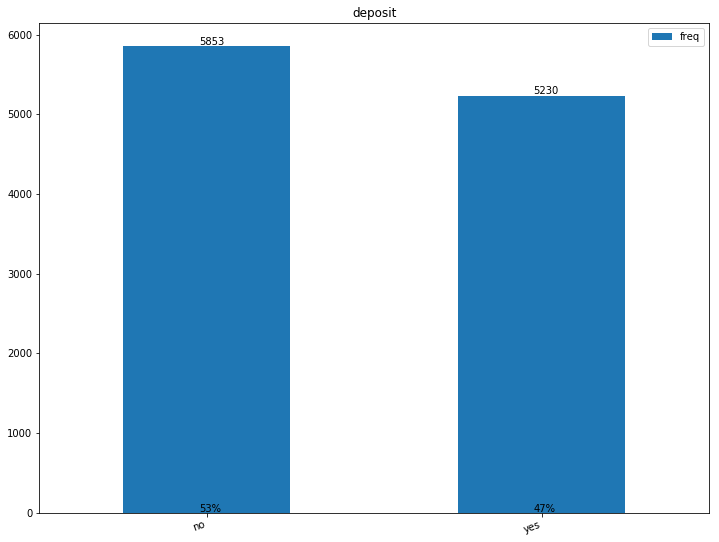

In [8]:
explore.plot_unique_values(categoric_feature='deposit')

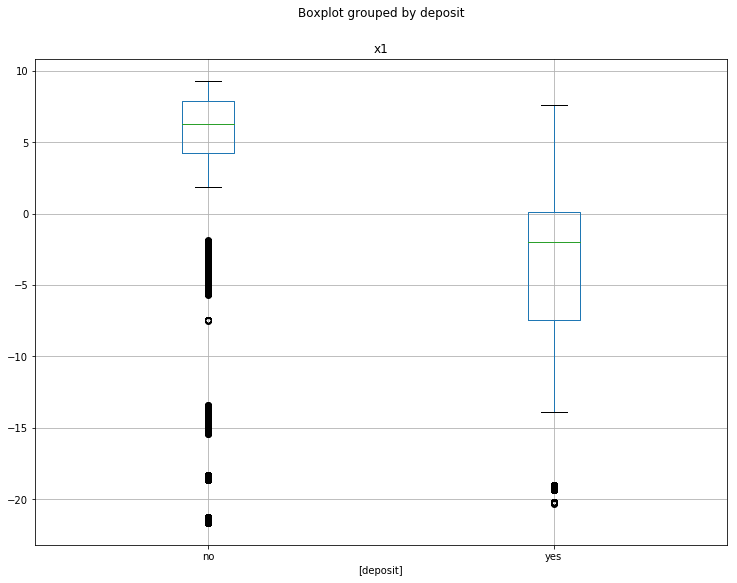

In [9]:
explore.plot_against_target(feature='x1')

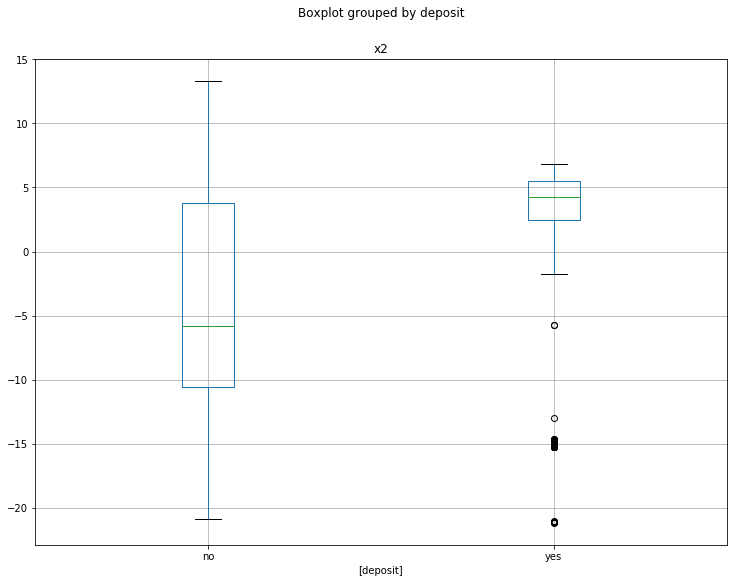

In [10]:
explore.plot_against_target(feature='x2')

Text(0,0.5,'x2')

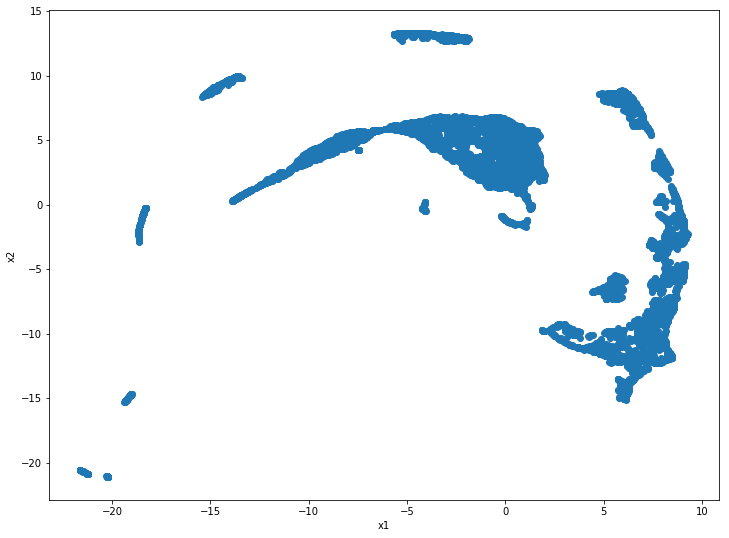

In [11]:
plt.scatter(x=explore.dataset.x1, y=explore.dataset.x2)
plt.xlabel('x1')
plt.ylabel('x2')

In [12]:
targets = list(set(explore.dataset.deposit))
targets

['yes', 'no']

In [13]:
import seaborn as sns
color_palette = sns.color_palette()[0:2]
color_palette

[(0.12156862745098039, 0.4666666666666667, 0.7058823529411765),
 (1.0, 0.4980392156862745, 0.054901960784313725)]

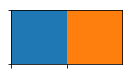

In [14]:
sns.palplot(color_palette)

Text(0,0.5,'x2')

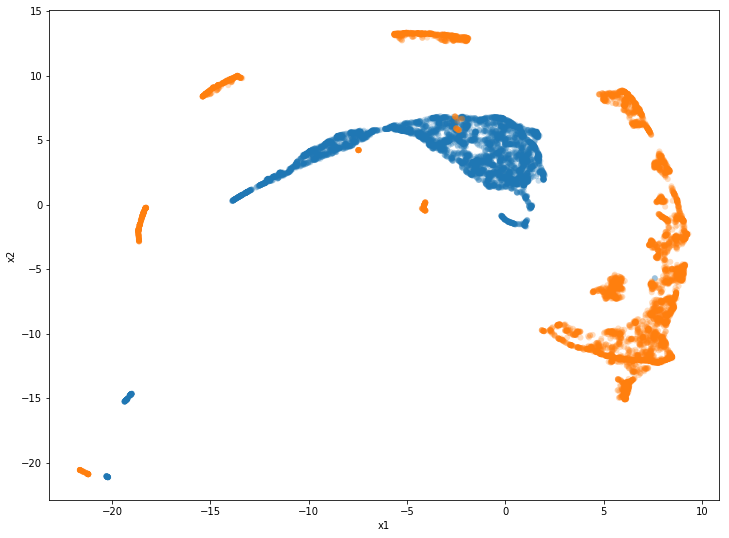

In [15]:
target_colors = [color_palette[0] if x == targets[0]
                  else color_palette[1]
                  for x in explore.dataset.deposit]
plt.scatter(x=explore.dataset.x1, y=explore.dataset.x2, linewidth=0, c=target_colors, alpha=0.25)
plt.xlabel('x1')
plt.ylabel('x2')

# K-means

Algorithm: 

- initialize `k` random `centroids`
- go through each of the data points and assigns the data points to the closest cluster centroid
- move the centroids to the average of the points in each cluster
- repeat until no change


- "What k-means essentially does is find cluster centers that minimize the sum of distances between data samples and their associated cluster centers."

## Search for the Ideal Cluster

In [16]:
transformations = [
    oo.RemoveColumnsTransformer(columns=['deposit']),
    oo.CenterScaleTransformer(),
]

num_clusters = list(range(2, 15))
num_clusters

[2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14]

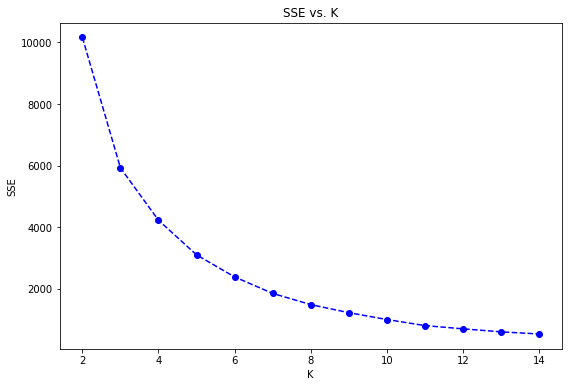

In [17]:
oo.Clustering.kmeans_elbow_sse_plot(data=explore.dataset,
                                    num_clusters=num_clusters,
                                    transformations=[x.clone() for x in transformations])

In [18]:
num_clusters = 6

## Cluster

In [19]:
trainer = oo.ModelTrainer(model=oo.ClusteringKMeans(),
                          model_transformations=[x.clone() for x in transformations],
                          scores=[oo.SilhouetteScore()],
                         )

clusters = trainer.train_predict_eval(data=explore.dataset,
                                      hyper_params=oo.ClusteringKMeansHP(num_clusters=num_clusters))

In [20]:
trainer.model.data_x_trained_head

,x1,x2
0,-1.074335,0.592354
1,-0.011687,0.874988
2,-0.036851,0.884368
3,-0.048311,0.581204
4,-0.003178,0.633777
5,-0.069894,0.496179
6,0.011987,0.857167
7,0.150721,0.509235
8,0.257974,0.310875
9,-0.368759,0.839227


In [21]:
clusters

array([2, 1, 1, ..., 0, 0, 0], dtype=int32)

In [22]:
len(set(clusters))

6

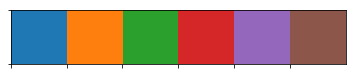

In [23]:
color_palette = sns.color_palette()[0:len(set(clusters))]
sns.palplot(color_palette)

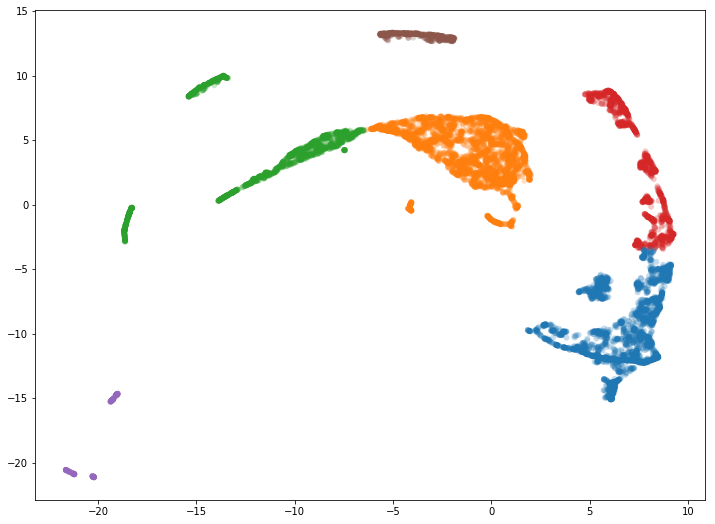

In [24]:
target_colors = [color_palette[x] for x in clusters]
plt.scatter(x=explore.dataset.x1, y=explore.dataset.x2, linewidth=0, c=target_colors, alpha=0.25)

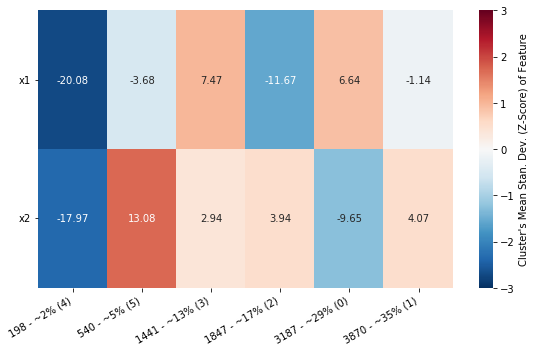

In [25]:
oo.Clustering.cluster_heatmap(data=explore.dataset.copy(),
                              clusters=clusters,
                              trans_strategy=oo.ClusteringHeatmapTransStrategy.CENTER_SCALE,
                              agg_strategy=oo.ClusteringHeatmapAggStrategy.MEAN,
                              display_values=oo.ClusteringHeatmapValues.ACTUAL,
                              color_scale_min=-3,
                              color_scale_max=3,
                              plot_size=(8, 5),
                             # axis_font_size=13,
                             # annotation_font_size=10
                             )

https://scikit-learn.org/stable/modules/generated/sklearn.metrics.silhouette_score.html

> Compute the mean Silhouette Coefficient of all samples.
>
> The Silhouette Coefficient is calculated using the mean intra-cluster distance (a) and the mean nearest-cluster distance (b) for each sample. The Silhouette Coefficient for a sample is (b - a) / max(a, b). To clarify, b is the distance between a sample and the nearest cluster that the sample is not a part of. Note that Silhouette Coefficient is only defined if number of labels is 2 <= n_labels <= n_samples - 1.
>
> This function returns the mean Silhouette Coefficient over all samples. To obtain the values for each sample, use silhouette_samples.
>
> The best value is 1 and the worst value is -1. Values near 0 indicate overlapping clusters. Negative values generally indicate that a sample has been assigned to the wrong cluster, as a different cluster is more similar.

In [26]:
trainer.training_scores[0].value

0.5697492607129984

In [27]:
temp_data = oo.TransformerPipeline(transformations=[x.clone() for x in transformations]).fit_transform(explore.dataset)

stats = oo.Clustering.silhouette_stats(clustered_data=temp_data, clusters=clusters)
stats.sort_values(by=['count'], ascending=False)

,count,mean,std,min,25%,50%,75%,max
1,3870.0,0.557847,0.123248,0.062935,0.495539,0.581615,0.654649,0.730761
0,3187.0,0.658420,0.143803,-0.010613,0.603680,0.718220,0.757125,0.779226
2,1847.0,0.455479,0.138058,-0.035904,0.375443,0.474445,0.582206,0.612135
3,1441.0,0.408857,0.151170,0.008845,0.298861,0.435864,0.569160,0.599406
5,540.0,0.847120,0.027469,0.793677,0.820602,0.851130,0.872867,0.882207
4,198.0,0.855559,0.017966,0.825151,0.842952,0.869688,0.871605,0.874461


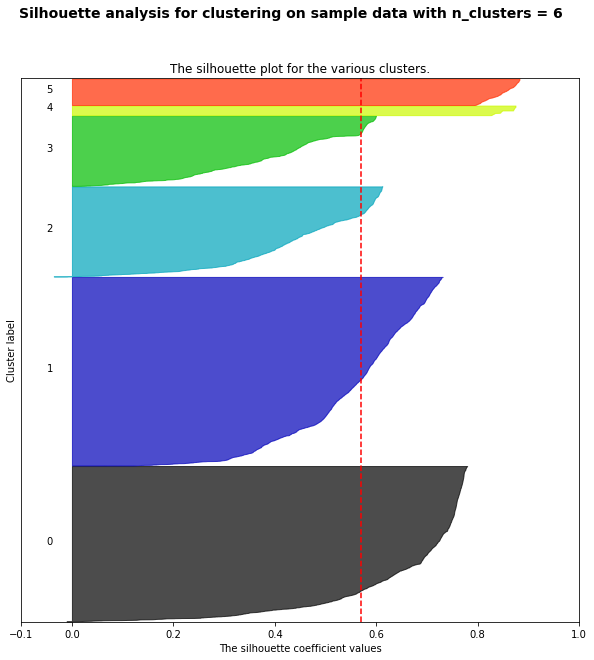

In [28]:
oo.Clustering.silhouette_plot(clustered_data=temp_data,
                              clusters=clusters,
                              figure_size=(10,10))

https://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_silhouette_analysis.html

The silhouette plot displays a measure of how close each point in one cluster is to points in the neighboring clusters and thus provides a way to assess parameters like number of clusters visually. This measure has a range of [-1, 1].

Red line is the average value of all the samples (i.e. the score from above)

The major thing to look for are the **"presence of clusters with below average silhouette scores and also due to wide fluctuations in the size of the silhouette plots"**

# Hierarchical

![dendogram](img/clustergram.png "Dendogram")

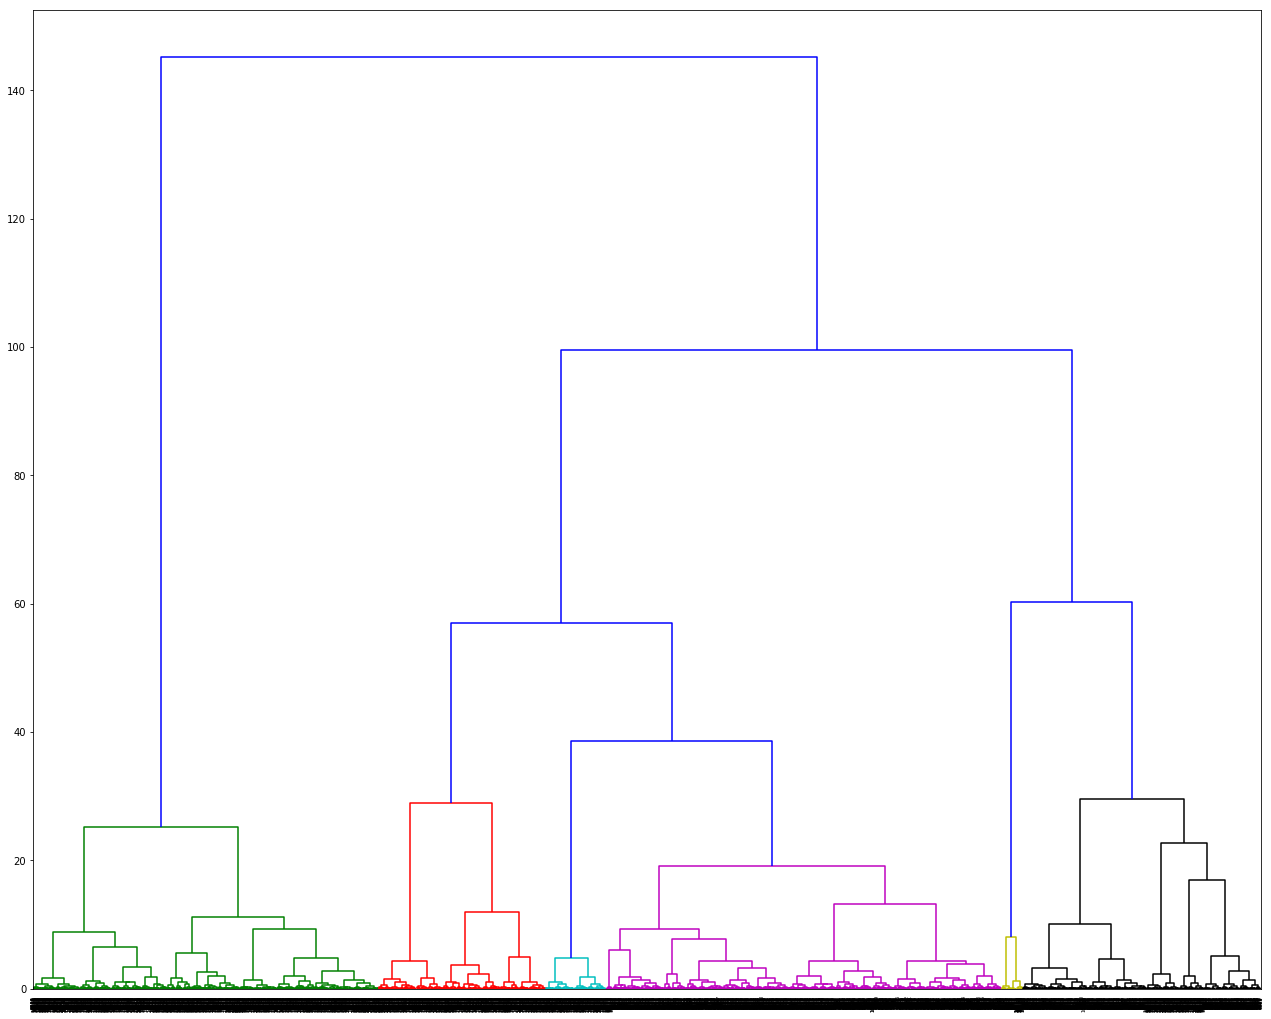

In [29]:
oo.Clustering.hierarchical_dendogram_plot(data=explore.dataset,
                                          transformations=[x.clone() for x in transformations],
                                          color_threshold=35)

In [30]:
num_clusters = 6

In [31]:
trainer = oo.ModelTrainer(model=oo.ClusteringHierarchical(),
                          model_transformations=[x.clone() for x in transformations],
                          scores=[oo.SilhouetteScore()],
                         )

clusters = trainer.train_predict_eval(data=explore.dataset,
                                      hyper_params=oo.ClusteringHierarchicalHP(num_clusters=num_clusters))

In [32]:
trainer.model.data_x_trained_head

,x1,x2
0,-1.074335,0.592354
1,-0.011687,0.874988
2,-0.036851,0.884368
3,-0.048311,0.581204
4,-0.003178,0.633777
5,-0.069894,0.496179
6,0.011987,0.857167
7,0.150721,0.509235
8,0.257974,0.310875
9,-0.368759,0.839227


In [33]:
clusters

array([0, 2, 2, ..., 4, 4, 4])

In [34]:
len(set(clusters))

6

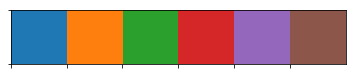

In [35]:
color_palette = sns.color_palette()[0:len(set(clusters))]
sns.palplot(color_palette)

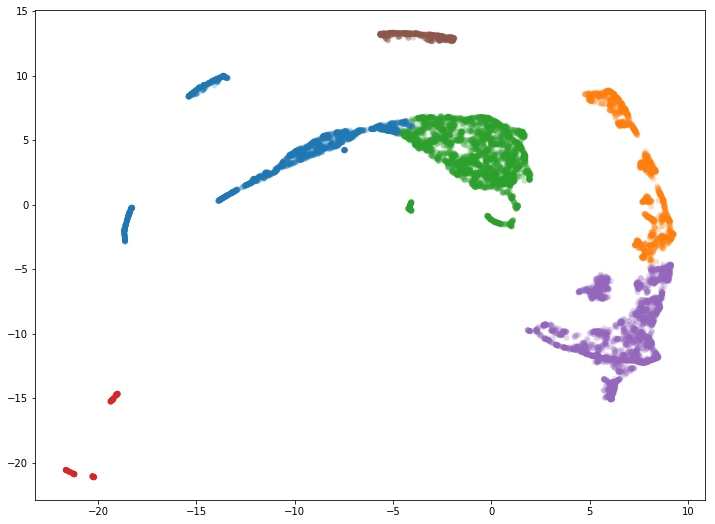

In [36]:
target_colors = [color_palette[x] for x in clusters]
plt.scatter(x=explore.dataset.x1, y=explore.dataset.x2, linewidth=0, c=target_colors, alpha=0.25)

kmean - 6, below

![kmeans_6](img/kmeans_6.png "kmeans_6")

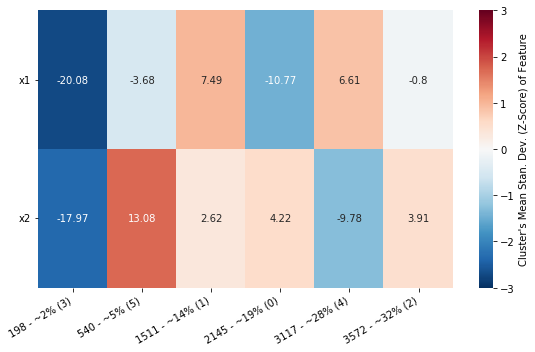

In [37]:
oo.Clustering.cluster_heatmap(data=explore.dataset.copy(),
                              clusters=clusters,
                              trans_strategy=oo.ClusteringHeatmapTransStrategy.CENTER_SCALE,
                              agg_strategy=oo.ClusteringHeatmapAggStrategy.MEAN,
                              display_values=oo.ClusteringHeatmapValues.ACTUAL,
                              color_scale_min=-3,
                              color_scale_max=3,
                              plot_size=(8, 5),
                             # axis_font_size=13,
                             # annotation_font_size=10
                             )

In [38]:
trainer.training_scores[0].value

0.5566118517483646

In [39]:
temp_data = oo.TransformerPipeline(transformations=[x.clone() for x in transformations]).fit_transform(explore.dataset)

stats = oo.Clustering.silhouette_stats(clustered_data=temp_data, clusters=clusters)
stats.sort_values(by=['count'], ascending=False)

,count,mean,std,min,25%,50%,75%,max
2,3572.0,0.593015,0.109219,0.305528,0.528731,0.612760,0.682031,0.750497
4,3117.0,0.664450,0.130448,0.197609,0.606097,0.719851,0.757826,0.781146
0,2145.0,0.368434,0.245289,-0.442486,0.318591,0.438899,0.553917,0.583816
1,1511.0,0.370707,0.167102,-0.205641,0.271295,0.387869,0.537931,0.583483
5,540.0,0.849962,0.027077,0.796207,0.824407,0.854022,0.875490,0.884480
3,198.0,0.859485,0.016943,0.830580,0.847735,0.872596,0.874641,0.877375


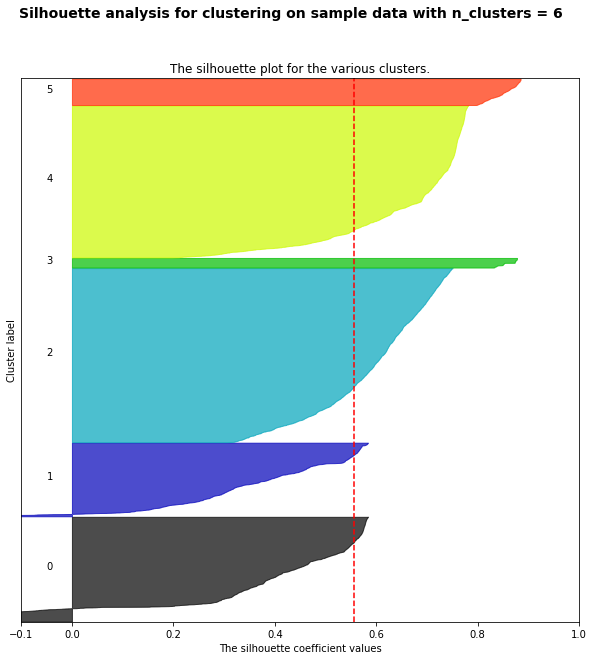

In [40]:
oo.Clustering.silhouette_plot(clustered_data=temp_data,
                              clusters=clusters,
                              figure_size=(10,10))

# HDBSCAN

### DBSCAN

https://scikit-learn.org/stable/modules/generated/sklearn.cluster.DBSCAN.html

> DBSCAN - Density-Based Spatial Clustering of Applications with Noise. Finds core samples of high density and expands clusters from them. Good for data which contains clusters of similar density.


https://hdbscan.readthedocs.io/en/latest/how_hdbscan_works.html


> HDBSCAN is a clustering algorithm that extends DBSCAN by converting it into a hierarchical clustering algorithm, and then using a technique to extract a flat clustering based in the stability of clusters. 


https://towardsdatascience.com/lightning-talk-clustering-with-hdbscan-d47b83d1b03a

> Regular DBScan is amazing at clustering data of varying shapes, but falls short of clustering data of varying density. 

> HDBScan is built for the real-world scenario of having data with varying density, it’s relatively fast, and it lets you define what clusters are important to you based on size.

https://hdbscan.readthedocs.io/en/latest/parameter_selection.html

> The primary parameter to effect the resulting clustering is `min_cluster_size`. Ideally this is a relatively intuitive parameter to select – set it to the smallest size grouping that you wish to consider a cluster. It can have slightly non-obvious effects however

> The simplest intuition for what `min_samples` does is provide a measure of how **conservative** you want you clustering to be. **The larger the value of min_samples you provide, the more conservative the clustering – more points will be declared as noise, and clusters will be restricted to progressively more dense areas.**

In [77]:
trainer = oo.ModelTrainer(model=oo.ClusteringHDBSCAN(),
                          model_transformations=[x.clone() for x in transformations],
                          scores=[oo.DensityBasedClusteringValidationScore()])
clusters = trainer.train_predict_eval(data=explore.dataset,
                                      hyper_params=oo.ClusteringHDBSCANHP(min_cluster_size=125, min_samples=125))

In [42]:
num_clusters = len(set(clusters))
num_clusters

14

In [43]:
np.sort(list(set(clusters)))

array([-1,  0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12])

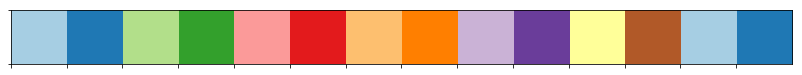

In [44]:
color_palette = sns.color_palette('Paired', len(set(clusters))) if num_clusters > 10 else sns.color_palette()[0:num_clusters]
sns.palplot(color_palette)

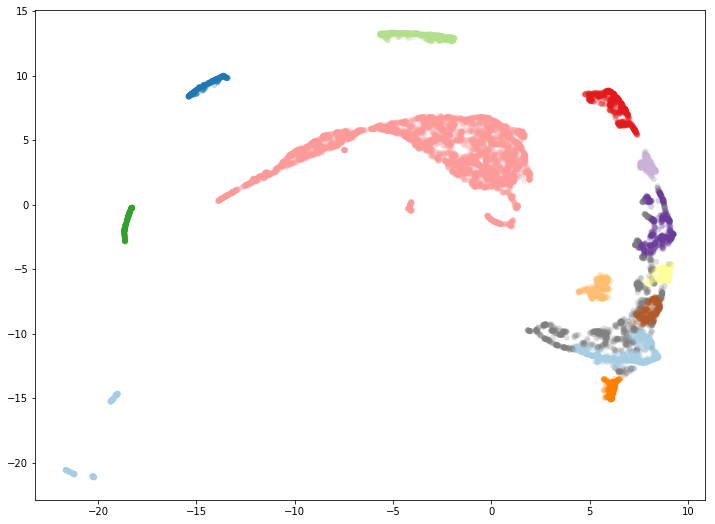

In [45]:
cluster_colors = [color_palette[x] if x >= 0
                  else (0.5, 0.5, 0.5)
                  for x in clusters]
plt.scatter(x=explore.dataset.x1, y=explore.dataset.x2, linewidth=0, c=cluster_colors, alpha=0.25)

Gray colors correspond to cluster `-1`

In [46]:
trainer.training_scores[0].value

0.4069430105103244

In [47]:
pd.Series(clusters).value_counts().sort_index()

-1     932 
 0     198 
 1     301 
 2     540 
 3     222 
 4     5194
 5     581 
 6     421 
 7     322 
 8     235 
 9     567 
 10    253 
 11    305 
 12    1012
dtype: int64

## 2

In [48]:
trainer = oo.ModelTrainer(model=oo.ClusteringHDBSCAN(),
                          model_transformations=[x.clone() for x in transformations],
                          scores=[oo.DensityBasedClusteringValidationScore()])
clusters = trainer.train_predict_eval(data=explore.dataset,
                                      hyper_params=oo.ClusteringHDBSCANHP(min_cluster_size=200, min_samples=200))

In [49]:
num_clusters = len(set(clusters))
num_clusters

7

In [50]:
np.sort(list(set(clusters)))

array([-1,  0,  1,  2,  3,  4,  5])

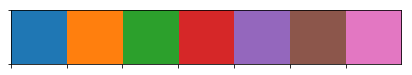

In [51]:
color_palette = sns.color_palette('Paired', len(set(clusters))) if num_clusters > 10 else sns.color_palette()[0:num_clusters]
sns.palplot(color_palette)

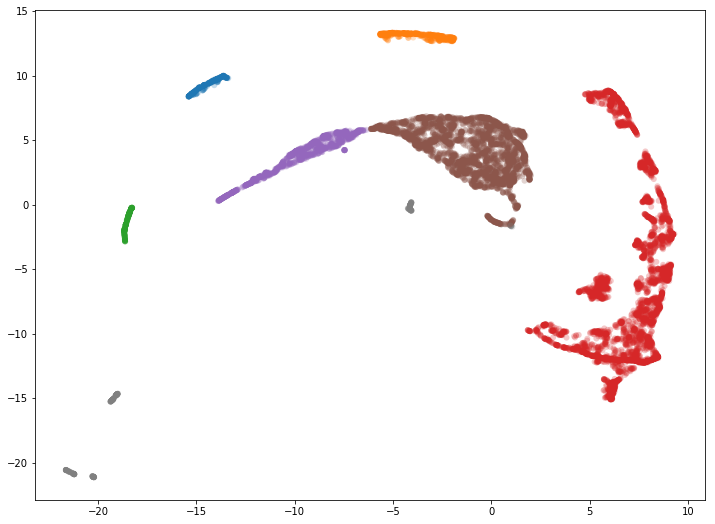

In [52]:
cluster_colors = [color_palette[x] if x >= 0
                  else (0.5, 0.5, 0.5)
                  for x in clusters]
plt.scatter(x=explore.dataset.x1, y=explore.dataset.x2, linewidth=0, c=cluster_colors, alpha=0.25)

Gray colors correspond to cluster `-1`

In [53]:
trainer.training_scores[0].value

0.0731658237039344

In [54]:
pd.Series(clusters).value_counts().sort_index()

-1    280 
 0    301 
 1    540 
 2    222 
 3    4628
 4    1325
 5    3787
dtype: int64

## 3

In [55]:
trainer = oo.ModelTrainer(model=oo.ClusteringHDBSCAN(),
                          model_transformations=[x.clone() for x in transformations],
                          scores=[oo.DensityBasedClusteringValidationScore()])
clusters = trainer.train_predict_eval(data=explore.dataset,
                                      hyper_params=oo.ClusteringHDBSCANHP(min_cluster_size=500, min_samples=50))

In [56]:
num_clusters = len(set(clusters))
num_clusters

6

In [57]:
np.sort(list(set(clusters)))

array([-1,  0,  1,  2,  3,  4])

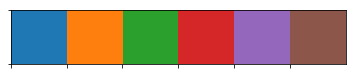

In [58]:
color_palette = sns.color_palette('Paired', len(set(clusters))) if num_clusters > 10 else sns.color_palette()[0:num_clusters]
sns.palplot(color_palette)

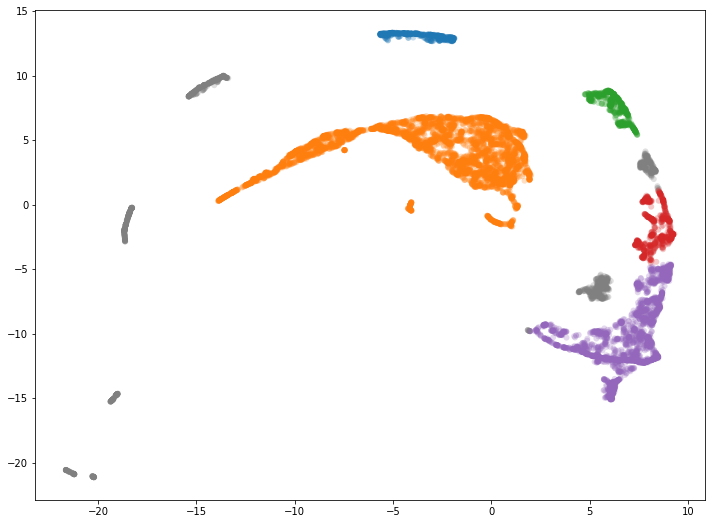

In [59]:
cluster_colors = [color_palette[x] if x >= 0
                  else (0.5, 0.5, 0.5)
                  for x in clusters]
plt.scatter(x=explore.dataset.x1, y=explore.dataset.x2, linewidth=0, c=cluster_colors, alpha=0.25)

Gray colors correspond to cluster `-1`

In [60]:
trainer.training_scores[0].value

0.11626894632682316

In [61]:
pd.Series(clusters).value_counts().sort_index()

-1    1392
 0    540 
 1    5194
 2    581 
 3    689 
 4    2687
dtype: int64

# Search

In [62]:
min_cluster_sizes = list(range(50, 300, 50))
min_cluster_sizes

[50, 100, 150, 200, 250]

In [63]:
min_samples = list(range(50, 300, 50))
min_samples

[50, 100, 150, 200, 250]

In [64]:
data = explore.dataset.copy()

model_infos = [
    oo.ModelInfo(model=oo.ClusteringKMeans(),
                 description='KMeans - CenterScale',
                 #transformations=[x.clone() for x in transformations],
                 hyper_params=oo.ClusteringKMeansHP(),
                 hyper_params_grid=oo.HyperParamsGrid(params_dict={'num_clusters': [2, 3, 4, 5, 6, 7, 8]})),
    oo.ModelInfo(model=oo.ClusteringHierarchical(),
                 description='Hierarchical - CenterScale',
                 #transformations=[x.clone() for x in transformations],
                 hyper_params=oo.ClusteringHierarchicalHP(),
                 hyper_params_grid=oo.HyperParamsGrid(params_dict={'num_clusters': [2, 3, 4, 5, 6, 7, 8]})),
    oo.ModelInfo(model=oo.ClusteringHDBSCAN(),
                 description='DBSCAN - CenterScale',
                 #transformations==[x.clone() for x in transformations],
                 hyper_params=oo.ClusteringHDBSCANHP(),
                 hyper_params_grid=oo.HyperParamsGrid(params_dict={'min_cluster_size': min_cluster_sizes,
                                                                   'min_samples': min_samples})),
]

searcher = oo.ClusteringSearcher(
    model_infos=model_infos,
    scores=[oo.SilhouetteScore(),
            oo.DensityBasedClusteringValidationScore()],
    global_transformations=[x.clone() for x in transformations],
)
results = searcher.search(data=data)

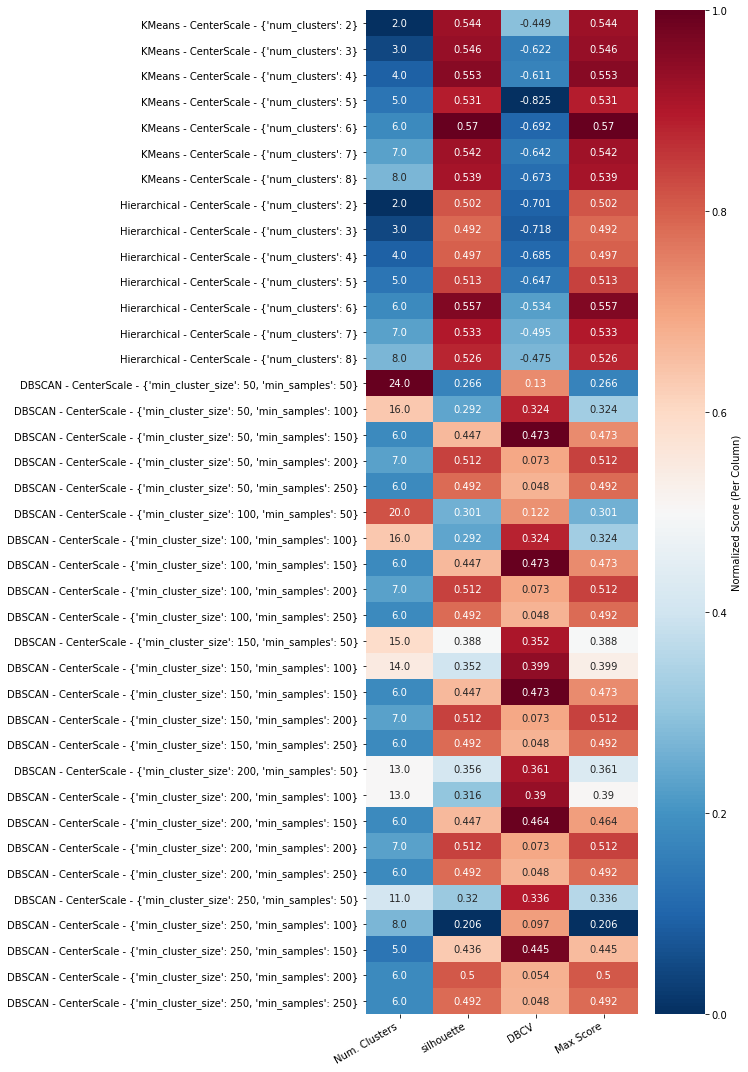

In [65]:
results.heatmap(figure_size=(10, 15))

In [66]:
indexes = (results.results['Max Score'] > 0.47) &\
          (results.results['Num. Clusters'] >= 4) &\
          (results.results['Num. Clusters'] < 8)
results.results[indexes].sort_values('silhouette', ascending=False).head(10)

,model,hyper_params,Num. Clusters,silhouette,DBCV,Max Score
4,KMeans - CenterScale,{'num_clusters': 6},6,0.569749,-0.691551,0.569749
4,Hierarchical - CenterScale,{'num_clusters': 6},6,0.556612,-0.534318,0.556612
2,KMeans - CenterScale,{'num_clusters': 4},4,0.553071,-0.611261,0.553071
5,KMeans - CenterScale,{'num_clusters': 7},7,0.541806,-0.642445,0.541806
5,Hierarchical - CenterScale,{'num_clusters': 7},7,0.533489,-0.494973,0.533489
3,KMeans - CenterScale,{'num_clusters': 5},5,0.531170,-0.825066,0.531170
3,Hierarchical - CenterScale,{'num_clusters': 5},5,0.512554,-0.647482,0.512554
13,DBSCAN - CenterScale,"{'min_cluster_size': 150, 'min_samples': 200}",7,0.511703,0.073166,0.511703
3,DBSCAN - CenterScale,"{'min_cluster_size': 50, 'min_samples': 200}",7,0.511703,0.073166,0.511703
8,DBSCAN - CenterScale,"{'min_cluster_size': 100, 'min_samples': 200}",7,0.511703,0.073166,0.511703


In [67]:
indexes = (results.results['Max Score'] > 0.47) &\
          (results.results['Num. Clusters'] >= 4) &\
          (results.results['Num. Clusters'] < 8)
results.results[indexes].sort_values('DBCV', ascending=False).head(10)

,model,hyper_params,Num. Clusters,silhouette,DBCV,Max Score
12,DBSCAN - CenterScale,"{'min_cluster_size': 150, 'min_samples': 150}",6,0.447391,0.473176,0.473176
2,DBSCAN - CenterScale,"{'min_cluster_size': 50, 'min_samples': 150}",6,0.447391,0.473176,0.473176
7,DBSCAN - CenterScale,"{'min_cluster_size': 100, 'min_samples': 150}",6,0.447391,0.473176,0.473176
8,DBSCAN - CenterScale,"{'min_cluster_size': 100, 'min_samples': 200}",7,0.511703,0.073166,0.511703
18,DBSCAN - CenterScale,"{'min_cluster_size': 200, 'min_samples': 200}",7,0.511703,0.073166,0.511703
13,DBSCAN - CenterScale,"{'min_cluster_size': 150, 'min_samples': 200}",7,0.511703,0.073166,0.511703
3,DBSCAN - CenterScale,"{'min_cluster_size': 50, 'min_samples': 200}",7,0.511703,0.073166,0.511703
23,DBSCAN - CenterScale,"{'min_cluster_size': 250, 'min_samples': 200}",6,0.500496,0.053876,0.500496
4,DBSCAN - CenterScale,"{'min_cluster_size': 50, 'min_samples': 250}",6,0.491534,0.048484,0.491534
19,DBSCAN - CenterScale,"{'min_cluster_size': 200, 'min_samples': 250}",6,0.491534,0.048484,0.491534


In [68]:
trainer = oo.ModelTrainer(model=oo.ClusteringHDBSCAN(),
                          model_transformations=[x.clone() for x in transformations],
                          scores=[oo.DensityBasedClusteringValidationScore()])
clusters = trainer.train_predict_eval(data=explore.dataset,
                                      hyper_params=oo.ClusteringHDBSCANHP(min_cluster_size=50, min_samples=150))

In [69]:
num_clusters = len(set(clusters))
num_clusters

6

In [70]:
np.sort(list(set(clusters)))

array([0, 1, 2, 3, 4, 5])

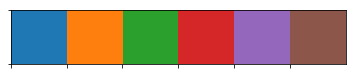

In [71]:
color_palette = sns.color_palette('Paired', len(set(clusters))) if num_clusters > 10 else sns.color_palette()[0:num_clusters]
sns.palplot(color_palette)

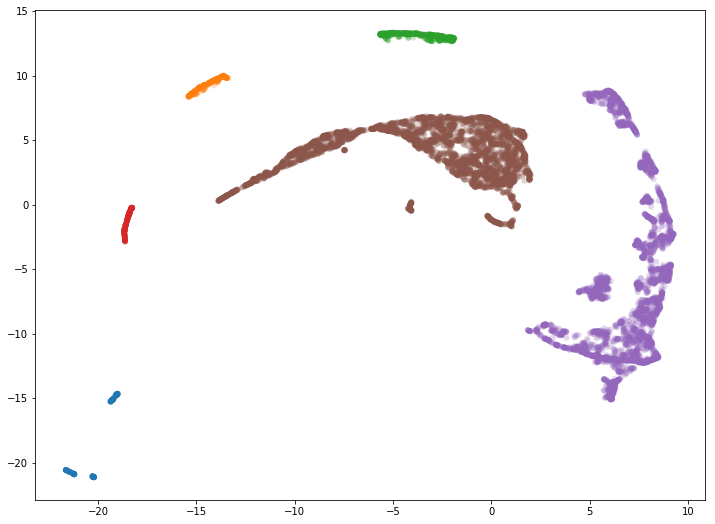

In [72]:
cluster_colors = [color_palette[x] if x >= 0
                  else (0.5, 0.5, 0.5)
                  for x in clusters]
plt.scatter(x=explore.dataset.x1, y=explore.dataset.x2, linewidth=0, c=cluster_colors, alpha=0.25)

![kmeans_6](img/dataset.png "kmeans_6")

In [73]:
trainer.training_scores[0].value

0.4731762912079922

In [74]:
pd.Series(clusters).value_counts().sort_index()

0    198 
1    301 
2    540 
3    222 
4    4628
5    5194
dtype: int64